In [2]:
from netCDF4 import Dataset
import cartopy
import xarray
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm
import matplotlib.ticker as mticker
import os
import nctoolkit as nct
import regex
from matplotlib.ticker import FormatStrFormatter
from cartopy.util import add_cyclic_point
from matplotlib import colors
import geopandas as gpd
import shapely.geometry as shp
import rioxarray
import pyproj
import pandas as pd

In [3]:
nct.deep_clean()

In [4]:
os.chdir('/media/jasmine/Album/Project/')
print(os.getcwd())

/media/jasmine/Album/Project


In [5]:
variable = "siconc"
print(variable)
model = "ACCESS-ESM1-5"
print(model)
experiment = "ssp585"
print(experiment)
freq = "SImon"
print(freq)

siconc
ACCESS-ESM1-5
ssp585
SImon


## Interpolation


In [7]:
for file in os.listdir("Data/Raw/"):
    if file.startswith("{}_{}_{}_{}".format(variable, freq, model, experiment)):
        print(file)

print("\n")

for file in os.listdir("Data/Raw/"):
    if file.startswith("{}_{}_{}_historical".format(variable, freq, model)):
        print(file)

siconc_SImon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc
siconc_SImon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_210101-230012.nc


siconc_SImon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc


In [8]:
!cdo remapdis,r360x180 Data/Raw/siconc_SImon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc Data/{variable}_{model}_{experiment}_remapped.nc

cdo    remapdis: Distance-weighted average weights from curvilinear (360x300) to lonlat (360x180) grid, with source mask (69782)
cdo    remapdis:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    remapdis: Processed 1 variable over 1032 timesteps [10.99s 216MB].


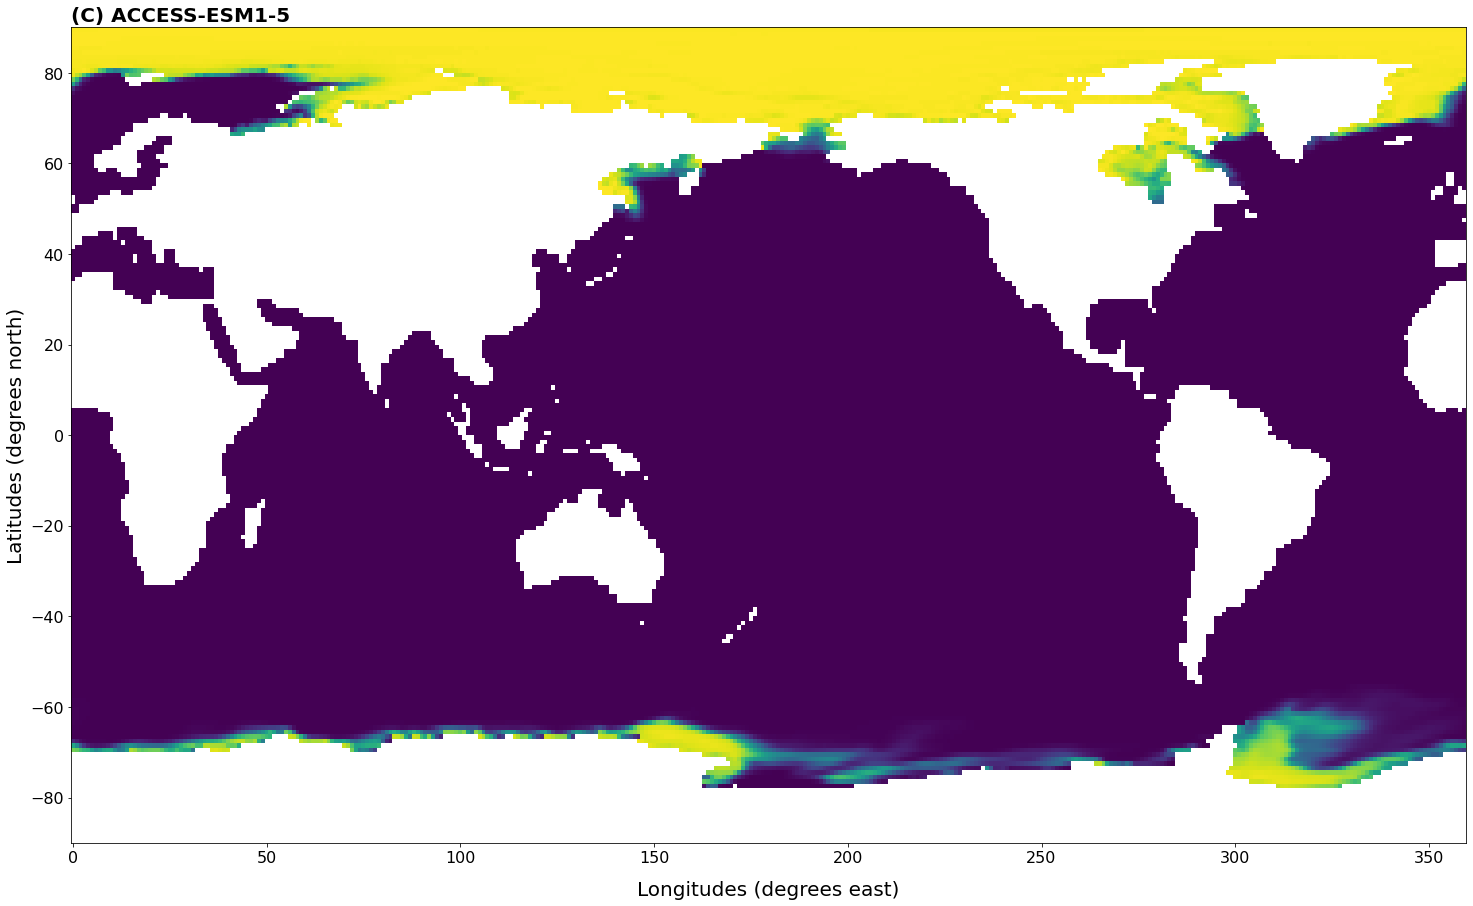

In [32]:
nc = xarray.open_dataset("Data/{}_{}_{}_remapped.nc".format(variable, model, experiment))
nc = nc.sel(time = "2015-01")

fig, axes = plt.subplots(figsize=(25,15))
plot = nc[variable].plot(ax=axes, add_colorbar = False, add_labels = False)

plt.title("(C) {}".format(model), fontsize = 20, fontweight = "bold", loc = "left")
plt.ylabel("Latitudes (degrees north)", fontsize = 20)
plt.xlabel("Longitudes (degrees east)", fontsize = 20, labelpad = 15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig("output/{}/{}_{}_{}_interpolation.png".format(model, variable, model, experiment))

plt.show()

In [10]:
!cdo remapdis,r360x180 Data/Raw/siconc_SImon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc Data/{variable}_{model}_historical_remapped.nc

cdo    remapdis: Distance-weighted average weights from curvilinear (360x300) to lonlat (360x180) grid, with source mask (69782)
cdo    remapdis:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    remapdis: Processed 1 variable over 1980 timesteps [19.27s 230MB].


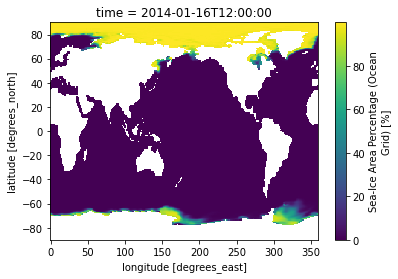

In [11]:
nc = xarray.open_dataset("Data/{}_{}_historical_remapped.nc".format(variable, model))
nc = nc.sel(time = "2014-01")
nc[variable].plot()

## Sea ice selection

#### Selecting mask region

In [12]:
nc = xarray.open_dataset("Data/{}_{}_historical_remapped.nc".format(variable, model))
nc = nc.sel(lat=slice(-90,0))
nc

<xarray.Dataset>
Dimensions:    (time: 1980, bnds: 2, lon: 360, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon        (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -3.5 -2.5 -1.5 -0.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    siconc     (time, lat, lon) float32 ...
Attributes: (12/49)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Mon Aug 08 23:03:02 2022: cdo remapdis,r360x180 D...
    source:                 ACCESS-ESM1.5 (2019): \naerosol: CLASSIC (v1.0)\n...
    institution:            Commonwealth Scientific and Industrial Research O...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    ...                     ...
    variant_label:          r1i1p1f1
    version:                v20200817
    license:                CMIP6 model data produced by CSIRO is licensed un...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/931b0664-d90c-46d5-b9fb-f7f17b8cefd5
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [13]:
# Selecting the last 20 years of historical
nc = nc.drop_vars("time_bnds")
history = nc.sel(time=slice('1995-01', '2014-12'))
history

<xarray.Dataset>
Dimensions:  (time: 240, lon: 360, lat: 90)
Coordinates:
  * time     (time) datetime64[ns] 1995-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... -3.5 -2.5 -1.5 -0.5
Data variables:
    siconc   (time, lat, lon) float32 ...
Attributes: (12/49)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Mon Aug 08 23:03:02 2022: cdo remapdis,r360x180 D...
    source:                 ACCESS-ESM1.5 (2019): \naerosol: CLASSIC (v1.0)\n...
    institution:            Commonwealth Scientific and Industrial Research O...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    ...                     ...
    variant_label:          r1i1p1f1
    version:                v20200817
    license:                CMIP6 model data produced by CSIRO is licensed un...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/931b0664-d90c-46d5-b9fb-f7f17b8cefd5
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [14]:
# Finding yearly max ice cover 
yearly_max = history.groupby("time.year").max("time")
yearly_max

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 90, year: 20)
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... -3.5 -2.5 -1.5 -0.5
  * year     (year) int64 1995 1996 1997 1998 1999 ... 2010 2011 2012 2013 2014
Data variables:
    siconc   (year, lat, lon) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0

In [15]:
# Calculating mean over 20 years
mean = yearly_max.mean(dim = "year")
mean

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 90)
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... -3.5 -2.5 -1.5 -0.5
Data variables:
    siconc   (lat, lon) float32 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0

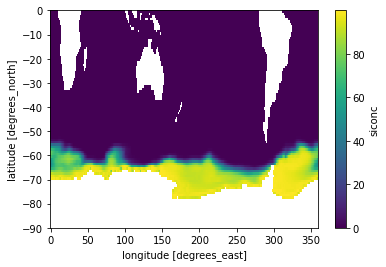

In [16]:
mean[variable].plot()

In [17]:
mean.to_netcdf(path = "Data/{}_{}_ice_extent.nc".format(variable, model), mode = "w", format = "NETCDF4")

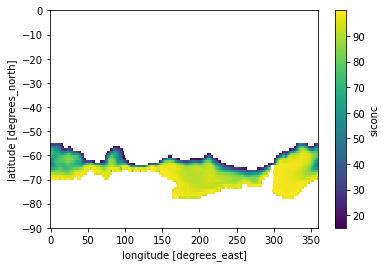

In [18]:
# Select cells with >15% ice cover
ice = mean.where(mean >= 15)
ice[variable].plot()

In [19]:
ice = ice.assign(ice = lambda x: getattr(x, variable) - getattr(x, variable) + 1)

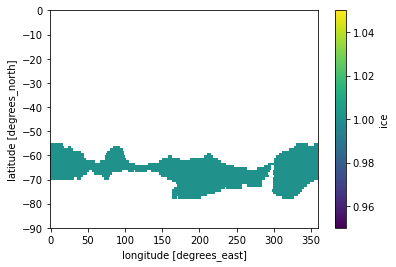

In [20]:
ice['ice'].plot()

In [21]:
ice = ice.drop_vars("siconc")
ice.to_netcdf(path = "Data/Shape/{}_{}_ice_region.nc".format(variable, model), mode = "w", format = "NETCDF4")

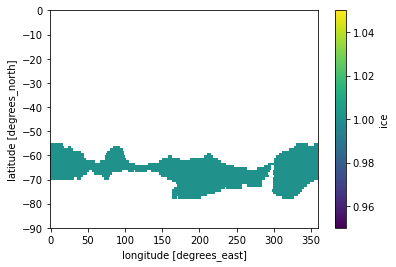

In [22]:
nc = xarray.open_dataset("Data/Shape/{}_{}_ice_region.nc".format(variable, model))
nc['ice'].plot()

### Making mask

In [5]:
shape = gpd.read_file("Shapes/{}_ice_margin.shp".format(model), crs = "EPSG:4326")
shape

,DN,geometry
0,1,"POLYGON ((-0.500 -55.000, 16.500 -55.000, 16.5..."


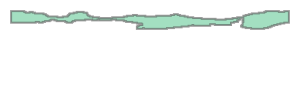

In [6]:
coord1 = shape['geometry'][0].exterior.coords
line1 = shp.LinearRing(coord1)
poly1 = shp.Polygon(line1)
poly1

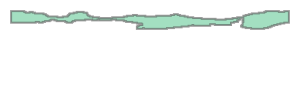

In [7]:
multi_poly = shp.MultiPolygon([poly1])
multi_poly

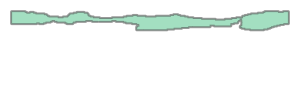

In [8]:
# Expand the region by 1 cells to include open sea
expand = shp.Polygon(multi_poly.buffer(1.0))
expand

In [9]:
ice_new = gpd.GeoSeries(expand)
ice_new

0    POLYGON ((-1.500 -55.000, -1.495 -54.902, -1.4...
dtype: geometry

In [10]:
ice_new.to_file(driver = 'ESRI Shapefile', filename= "Shapes/{}_extended_ice_margin.shp".format(model))

In [11]:
ice_new.crs = {'init' :'epsg:4326'}

/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6


<AxesSubplot:>

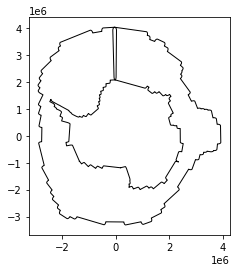

In [12]:
df_ae = ice_new.to_crs("epsg:3031")
df_ae.plot(facecolor="none", edgecolor="black")

In [13]:
df_ae.to_file(driver = 'ESRI Shapefile', filename= "Shapes/{}_ice_margin_remapped.shp".format(model))